# Example notebook showing how to run the CASTOR grism ETC
# This notebook uses a Sersic2D profile as the source image and a spectrum read from a file for the source spectrum.

## WARNING: This is an early version (0.0.2) of the grism ETC, and improvement is still underway. The current version demonstrates how to use the tool but changes in the specification files or the tool itself may occur and current results should be taken with caution.

# 0 - imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ETC_grism_dev
from ETC_grism_dev import background
from ETC_grism_dev import spectrum
from ETC_grism_dev import disperser
from ETC_grism_dev import utils

# 1 - Create the direct image source using a Sersic2D profile

In [2]:
#Use a sersic profile
from astropy.modeling.models import Sersic2D
pix_scale = 0.1 #telescope pixel scale in arcsec
source_eff_radius_arcsec = 3/7.5 #arcsec
source_eff_radius_pixels = source_eff_radius_arcsec/pix_scale
box_size = source_eff_radius_pixels * 4

x,y = np.meshgrid(np.arange(box_size), np.arange(box_size))

sersic_model = Sersic2D(amplitude = 1, r_eff = source_eff_radius_pixels, n=1, x_0=box_size/2, y_0=box_size/2,
               ellip=.35, theta=-1)
source_image = sersic_model(x, y)

#source segmentation region (boolean)
#"True" pixels will be dispersed, while "False" will be ignored
source_seg = source_image/np.max(source_image) > 1e-2


/var/folders/x4/732lcbsj15v9fwvrd_hmx_jr0000gn/T/ipykernel_81548/3887003000.py:9: MatplotlibDeprecationWarning: 
The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([-1, 0, 1], update_ticks=True)


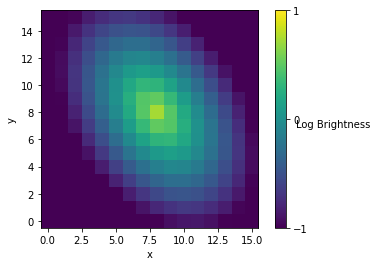

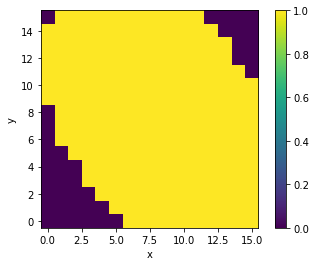

In [3]:
#view source
plt.figure()
plt.imshow(np.log10(source_image), origin='lower', interpolation='none',
           vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=0, labelpad=25)
cbar.set_ticks([-1, 0, 1], update_ticks=True)

#view seg region
plt.figure()
plt.imshow(source_seg, origin='lower', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# 2 - Get the source spectrum from file

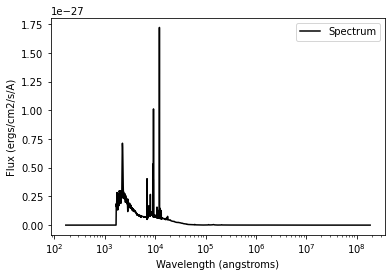

0

In [19]:
#Here we use a source spectrum from file.
#It assumes that wavelengths are in angstroms and fluxes in ergs/cm2/s/A
#The user can provide their own spectrum/file has long as they are in the same format as the example files in 'files/spectra/'.
#The user can also generate an FSPS spectrum using the tool (see the 'grism_etc_example.ipynb' notebook).
#The user can also generate its own spectrum that can be then passed to the spectrum object with:
#spectrum.spectrum = (wave, flux)
#where 'wave' is the 1D wavelength array in angstroms, and 'flux' is the 1D flux array in ergs/cm2/s/A.

#path_to_file = utils.ETC_GRISM_HOME+'files/spectra/fsps_quiescent.txt' #quiescent galaxy spectrum
path_to_file = utils.ETC_GRISM_HOME+'files/spectra/fsps_star_forming.txt' #star forming galaxy spectrum
wave_key = 'wavelength' #wavelength keyword
flux_key = 'flux' #flux keyword
redshift = 0.85 #if a redshift > 0 is provided, the file spectrum will be redshifted to that redshift.
spectrum.spectrum_from_file(spectrum, path_to_file, wave_key, flux_key, redshift=redshift, check=True)


TARGET_FLAM, NON_NORM_FLAM, SCALING:  1.4074277929769683e-17 2.753958215112561e-28 51105633529.71727
NORM_FLAM, NORM_FNU, NORM_MAG:  1.4074277929769683e-17 2.2908676527677887 22.999999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  1.4074277929769683e-17 2.2908676527677887 23


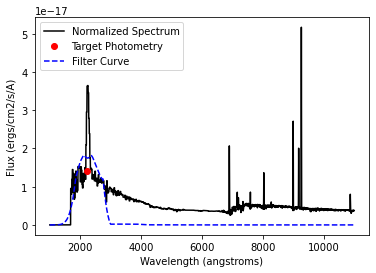

0

In [20]:
#Normalize spectrum to a given mag in one of the CASTOR filters (uv, u or g).
source_mag = 23
filter_channel = "uv"
spectrum.normalize_spectrum(spectrum, magnitude=source_mag, filter_channel=filter_channel, check=True)


# 3 - Disperse the source spectrum with the appropriate grism ("uv" or "u")

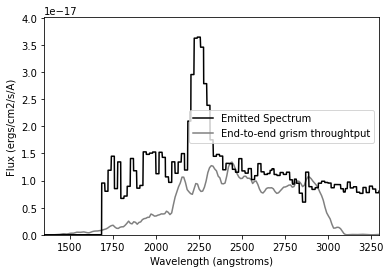

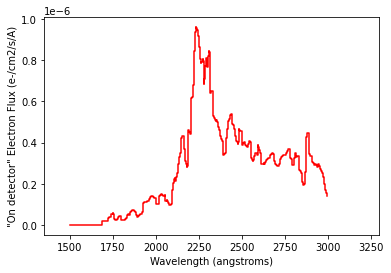

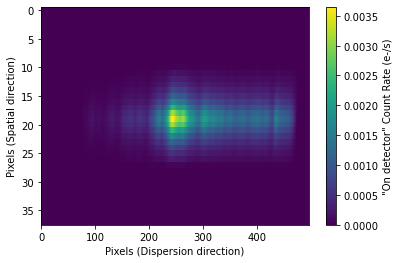

0

In [37]:
#The spectrum is dispersed pixel by pixel, only pixels within the source_disperse_region are dispersed.
source_spectrum = spectrum.spectrum
grism_channel = "uv" #disperse the spectrum with the uv-band grism.

#disperse
disperser.disperse(disperser, source_image=source_image, source_disperse_region=source_seg, 
                   source_spectrum=source_spectrum, grism_channel=grism_channel, check=True)


# 4 - Create the (count rate) sky background

In [56]:
#The user can specify their own zodical, earthshine and geocoronal.
#By default this uses the zodical and earthshine also provided in the imaging ETC.
#Three simulated geocoronal spectrum are available by default depending on the line intensities ('high', 'avg', 'low'),
#with line intensities taken from https://hst-docs.stsci.edu/stisihb/chapter-6-exposure-time-calculations/6-6-tabular-sky-backgrounds
#To use your own background, 'user_zodi', 'user_earthshine', and 'user_geo' should be a path to the approriate files,
#in the same format and structure as the default ones; and 'default_sky' should be set to False.
background.recompute_sky_background(background, default_sky=True, geo_intensity='avg', user_zodi=None, user_earthshine=None, user_geo=None)


0

In [57]:
print("sky background [e-/s/pix]:", background.sky_background_countrate) #with 'avg' geocoronal: {'uv': 0.004671128308536505, 'u': 0.014181008896939849}. Without geocoronal: {'uv': 0.0005811746388609881, 'u': 0.01418100467547261}
print("dark current [e-/s/pix]:", background.dark_countrate) #0.0001
print("read noise [e-/pix]:", background.read_noise_count) #2
print("----")

#The user can also specify their own sky background, dark current, and read noise values
#by modifying the appropriate background objects (/!\ this overrides previous background values):
#eg:
# background.sky_background_countrate = {'uv': 0.0005811746388609881, 'u': 0.01418100467547261}
# background.dark_countrate = 1e-4
# background.read_noise_count = 2
# print("NEW sky background [e-/s/pix]:", background.sky_background_countrate)
# print("NEW dark current [e-/s/pix]:", background.dark_countrate)
# print("NEW read noise [e-/pix]:", background.read_noise_count)

sky background [e-/s/pix]: {'uv': 0.004671128308536505, 'u': 0.014181008896939849}
dark current [e-/s/pix]: 0.0001
read noise [e-/pix]: 2
----


# 5 - Observe source for X seconds.

In [58]:
#Create first the noiseless integrated grism spectrum.
exposure_time = 1000 #in seconds
disperser.expose(disperser, exposure_time=exposure_time)
#The 2D exposure (in counts [e-]), is in: 'disperser.integrated_grism_box_count'


0

In [59]:
#Get the total signal + sky + detector noise of the exposure (in the same filter as the noiseless grism spectrum)
Nreads = 1 #number of read-outs during total exposition.
disperser.total_noise(disperser, exposure_time=exposure_time, filter=grism_channel, Nreads=Nreads, Nbin=1)
#The 2D total noise is in: 'disperser.grism_noise_total'


0

# 6 - Access spectrum and noise data to get an SNR

Text(0.5, 0, 'Pixels (Dispersion direction)')

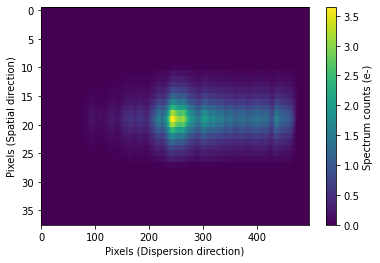

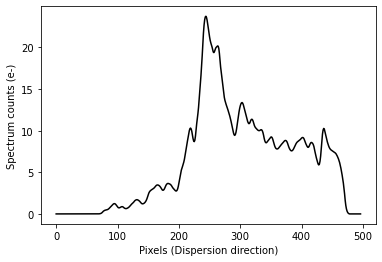

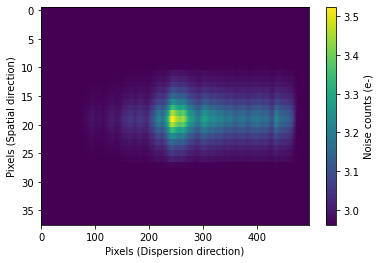

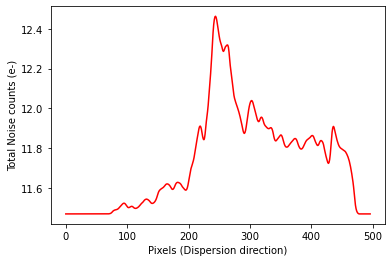

In [60]:
#Show noisless spectrum (in total counts)
#The noiseless data is in: disperser.integrated_grism_box_count
plt.imshow(disperser.integrated_grism_box_count, aspect="auto", interpolation="none")
plt.colorbar(label='Spectrum counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')
#1D spectrum (extracted within spatial extent of source image defined in step 1)
plt.figure()
box_center = int((disperser.integrated_grism_box_count.shape[0]-1) / 2)
half_source_size = int((source_image.shape[0]-1) / 2)
grism_1d = np.sum(disperser.integrated_grism_box_count[box_center-half_source_size:box_center+half_source_size+1,:],
                  axis=0)
grism_1d_x = np.arange(0,len(grism_1d), 1)
plt.plot(grism_1d_x, grism_1d, '-k')
plt.ylabel('Spectrum counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')

#Show signal+sky+detector noise (in total counts)
#The total signal+sky+detector noise is in disperser.grism_noise_total
plt.figure()
plt.imshow(disperser.grism_noise_total, aspect="auto", interpolation="none")
plt.colorbar(label='Noise counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')
#1D
#The 1D noise is shown here as the error sum at each wavelength along spatial axis.
#Also extracted within spatial extent of source image
plt.figure()
totnoise_1d = np.sqrt(np.sum(disperser.grism_noise_total[box_center-half_source_size:box_center+half_source_size+1,:]**2,
                             axis=0))
plt.plot(grism_1d_x, totnoise_1d, '-r')
plt.ylabel('Total Noise counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')


Text(0.5, 0, 'Pixels (Dispersion direction)')

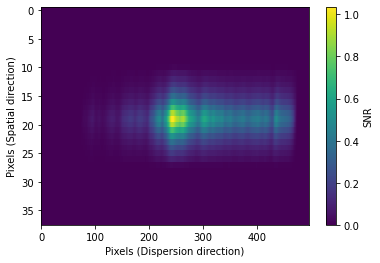

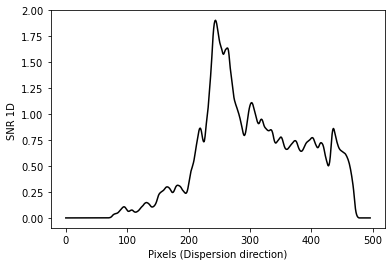

In [61]:
#Show SNR per resolution element
plt.imshow(disperser.integrated_grism_box_count/disperser.grism_noise_total, aspect="auto", interpolation="none")
plt.colorbar(label='SNR')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')


#Show as 1D
#1D noise taken here as the error sum at each wavelength along spatial axis.
#Extracted within spatial extent of source image
plt.figure()
sum_signal_1d = np.sum(disperser.integrated_grism_box_count[box_center-half_source_size:box_center+half_source_size+1,:], 
                       axis=0)
quad_error_1d = np.sqrt(np.sum(disperser.grism_noise_total[box_center-half_source_size:box_center+half_source_size+1,:]**2, 
                               axis=0))
snr_1d = sum_signal_1d / quad_error_1d
plt.plot(grism_1d_x, snr_1d, '-k')
plt.ylabel('SNR 1D ')
plt.xlabel('Pixels (Dispersion direction)')
